In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)
%cd /content/drive

Mounted at /content/drive
/content/drive


In [3]:
!pip install unidecode
!pip install fasttext

     |████████████████████████████████| 245kB 7.6MB/s 
     |████████████████████████████████| 71kB 4.7MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.2-cp36-cp36m-linux_x86_64.whl size=3041273 sha256=9a1fa08c6c422e1bc3f66cdcbc971891229f04a39d4075f4b053ffb83b30b7f8
  Stored in directory: /root/.cache/pip/wheels/98/ba/7f/b154944a1cf5a8cee91c154b75231136cc3a3321ab0e30f592
Successfully built fasttext


# IMPORTS

Here all imports are carried out for the whole projects.

In [4]:
#########################################
############### IMPORTS #################
#########################################

import sys
sys.path.append('/content/drive/MyDrive/DL_Corti/code/')
data_path = "/content/drive/MyDrive/DL_Corti/data/"

import pandas as pd
import numpy as np
import unidecode
import re
import string

from nltk.corpus import stopwords
from nltk.stem.snowball import EnglishStemmer

from sklearn.feature_extraction.text import TfidfVectorizer

from typing import *
from torch.utils.data import DataLoader
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import seaborn as sns
import random

sns.set_style("whitegrid")

import math 
import torch
from torch import nn, Tensor
from torch.nn.functional import softplus
from torch.distributions import Distribution
from scipy.sparse import coo_matrix
from plotting import make_vae_plots

from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.transforms import ToTensor
from functools import reduce

import fasttext

# from importDatasets import mUSA_train, mUSA_test, tfidf_politic, tfidf_UK

## Functions to clean

In [5]:
#@title
def tokenize(cell):
  regex_str = [
    r'(?:(?:\d+,?)+(?:\.?\d+)?)',   # numbers
    r"(?:[a-z][a-z\-_]+[a-z])",     # words with -
    r'(?:[\w_]+)',                  # other words
    r'(?:\S)'                       # anything else
  ]
  cell = unidecode.unidecode(cell)
  tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
  return tokens_re.findall(cell.lower())
    
def remove_stop_words(cell):
  stop_words = stopwords.words('english')
  return [word for word in cell if word not in stop_words]

def remove_punctation(cell):
  punctuation = string.punctuation
  return [word for word in cell if word not in punctuation]

def get_stemmed_text(cell):
  stemmer = EnglishStemmer()
  return [stemmer.stem(word) for word in cell]

def clean(col):
  col = col.apply(lambda x: tokenize(x))
  col = col.apply(lambda x: remove_stop_words(x))
  col = col.apply(lambda x: remove_punctation(x))
  col = col.apply(lambda x: get_stemmed_text(x))
  col = col.apply(lambda x: ' '.join(x))
  return col

def cleanAll(df):
  df = clean(df[df.columns[0]])
  return df

In [6]:
cleaner = False

if cleaner:
    ##Faster reading txt !!!
    df_politic = pd.read_csv(data_path+'df_politic.txt')
    
    df_tweetUK = pd.read_csv(data_path+'df_tweet_uk.txt', dtype=str, na_filter = False)
    df_tweetUK=df_tweetUK.rename(columns={'Tweet content': 'text'})
    
    df_tweetUSA = pd.read_csv(data_path+'df_tweet_usa.txt', dtype=str, na_filter = False)
    df_tweetUSA=df_tweetUSA.rename(columns={'Tweet content': 'text'})
else:
    ##Faster reading txt !!!
    df_politic = pd.read_csv(data_path+'df_politic_c.txt', dtype=str, na_filter = False)
    
    df_tweetUK = pd.read_csv(data_path+'df_tweetUK_c.txt', dtype=str, na_filter = False)
    df_tweetUK = df_tweetUK.rename(columns={'Tweet content': 'text'})
    
    df_tweetUSA = pd.read_csv(data_path+'df_tweetUSA_c.txt', dtype=str, na_filter = False)
    df_tweetUSA = df_tweetUSA.rename(columns={'Tweet content': 'text'})

#flattening nested list -> list of strings
df_politic_l = [item for items in df_politic.values.tolist() for item in items]
df_tweetUK_l = [item for items in df_tweetUK.values.tolist() for item in items]
df_tweetUSA_l = [item for items in df_tweetUSA.values.tolist() for item in items]

# random.shuffle(x, random)
random.shuffle(df_politic_l)
random.shuffle(df_tweetUK_l)
random.shuffle(df_tweetUSA_l)

df=pd.concat([df_politic,df_tweetUK,df_tweetUSA])
df = [item for items in df.values.tolist() for item in items]

# df=df['text']

In [7]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True, min_df=0.0001)

vec = tfidf_vectorizer.fit(df)
tfidf_politic = vec.transform(df_politic_l)
tfidf_UK = vec.transform(df_tweetUK_l)
tfidf_USA = vec.transform(df_tweetUSA_l)

percentage_train=0.9

mP_train = tfidf_politic[0:int(np.ceil(5000*percentage_train))]
mP_test = tfidf_politic[int(np.ceil(5000*percentage_train)):]

mUK_train = tfidf_UK[0:int(np.ceil(169033*percentage_train))]
mUK_test = tfidf_UK[int(np.ceil(169033*percentage_train)):]

mUSA_train = tfidf_USA[0:int(np.ceil(204820*percentage_train))]
mUSA_test = tfidf_USA[int(np.ceil(204820*percentage_train)):]

cat1= "love"
cat2= "peace"
cat3= "technology"
matching1 = [s for s in df_politic_l if cat1 in s]
matching2 = [s for s in df_tweetUK_l if cat2 in s]
matching3 = [s for s in df_tweetUSA_l if cat3 in s]
matching1 = matching1[0:10]
matching2 = matching2[0:10]
matching3 = matching3[0:10]
matching = matching1 + matching2 + matching3
tfidf_matching= vec.transform(matching)
print(len(matching))
y = [1 for i in range(len(matching1))] + [2 for i in range(len(matching2))] + [3 for i in range(len(matching3))]
print(y)

data_points= len(df_tweetUSA_l)*percentage_train

24
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3]


In [8]:
class ReparameterizedDiagonalGaussian(Distribution):
    """
    A distribution `N(y | mu, sigma I)` compatible with the reparameterization trick given `epsilon ~ N(0, 1)`.
    """
    def __init__(self, mu: Tensor, log_sigma:Tensor):
        assert mu.shape == log_sigma.shape, f"Tensors `mu` : {mu.shape} and ` log_sigma` : {log_sigma.shape} must be of the same shape"
        self.mu = mu
        self.sigma = log_sigma.exp()
        
    def sample_epsilon(self) -> Tensor:
        """`\eps ~ N(0, I)`"""
        return torch.empty_like(self.mu).normal_()
        
    def sample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (without gradients)"""
        with torch.no_grad():
            return self.rsample()
        
    def rsample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (with the reparameterization trick) """
        return self.mu + self.sigma*self.sample_epsilon() # <- your code
        #: let z ∼ p(z|x) = N (µ, σ2). In this case, a valid reparameterization is z = µ + σ eps, where eps is an auxiliary noise variable eps - N (0, 1).
   
    def log_prob(self, z:Tensor) -> Tensor:
        """return the log probability: log `p(z)`"""
       # d=Normal(loc=self.mu, scale=self.sigma)
        return  -((z - self.mu)** 2) / (2 * self.sigma**2) - self.sigma.log() -math.log(math.sqrt(2 * math.pi))  # <- your code
    
    
from torch.distributions import Bernoulli #<- your code
p = Bernoulli(logits=torch.zeros((1000,)))
# plt.figure(figsize=(12, 3))
# sns.distplot(p.sample())
# plt.title(r"$\mathcal{B}(\mathbf{y} \mid \mathbf{\theta})$")
# plt.show() 

In [9]:


#########################################################################################################################

# # # Flatten the images into a vector
# flatten = lambda x: ToTensor()(x).view(28**2)

# # Define the train and test sets
# dset_train = MNIST("./", train=True,  transform=flatten, download=True)
# dset_test  = MNIST("./", train=False, transform=flatten)

# # The digit classes to use
# classes = [ 4, 9]
# #[3, 7]

# def stratified_sampler(labels):
#     """Sampler that only picks datapoints corresponding to the specified classes"""
#     (indices,) = np.where(reduce(lambda x, y: x | y, [labels.numpy() == i for i in classes]))
#     indices = torch.from_numpy(indices)
#     return SubsetRandomSampler(indices)

# batch_size = 64
# eval_batch_size = 100
# # The loaders perform the actual work
# train_loader = DataLoader(dset_train, batch_size=batch_size,
#                           sampler=stratified_sampler(dset_train.train_labels))
# test_loader  = DataLoader(dset_test, batch_size=eval_batch_size, 
#                           sampler=str

def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()
    values = coo.data
    indices = np.vstack((coo.row, coo.col))
    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = coo.shape
    
    return torch.sparse.FloatTensor(i, v, torch.Size(shape)).to_dense()

def batch_generator(X_data, batch_size, infinite=None ):
    samples_per_epoch = X_data.shape[0]
    number_of_batches = (samples_per_epoch/batch_size)-1
    counter=0
    index = np.arange(np.shape(X_data)[0])
    if infinite == True:
        while 1:
            index_batch = index[batch_size*counter:batch_size*(counter+1)]
            #idx = np.random.permutation(len())
            X_batch = convert_sparse_matrix_to_sparse_tensor(X_data[index_batch,:])
            counter += 1
            yield X_batch
            if counter > number_of_batches:
                index = np.arange(np.shape(X_data)[0])
                np.random.shuffle(index)
                X_data[index, :]     
                counter= 0
    while counter < number_of_batches:
        index_batch = index[batch_size*counter:batch_size*(counter+1)]
        X_batch = convert_sparse_matrix_to_sparse_tensor(X_data[index_batch,:])
        counter += 1
        yield X_batch
        
batch_size = 256
eval_batch_size = 256
# The loaders perform the actual work
train_loader = batch_generator(mUSA_train, batch_size, infinite = True)

test_loader  = batch_generator(mUSA_test, eval_batch_size, infinite = True)
test_loader_politic  = batch_generator(tfidf_politic, eval_batch_size, infinite = True)
test_loader_UK  = batch_generator(tfidf_UK, eval_batch_size, infinite = True)

matches = convert_sparse_matrix_to_sparse_tensor(tfidf_matching)


###  power of 2 = 256, 512 ...

#plot a few tfidf examples
#f, axarr = plt.subplots(4, 16, figsize=(16, 4))

# Load a batch of images into memory
tfidf_m = next(iter(train_loader))

# for i, ax in enumerate(axarr.flat):
#     ax.spy(tfidf_m[i])
#     ax.axis('off')
    
# plt.show()

In [10]:
class VariationalAutoencoder(nn.Module):
    """A Variational Autoencoder with
    * a Bernoulli observation model `p_\theta(x | z) = B(x | g_\theta(z))`
    * a Gaussian prior `p(z) = N(z | 0, I)`
    * a Gaussian posterior `q_\phi(z|x) = N(z | \mu(x), \sigma(x))`
    """
    
    def __init__(self, input_shape:torch.Size, latent_features:int) -> None:
        super(VariationalAutoencoder, self).__init__()
        
        self.input_shape = input_shape
        self.latent_features = latent_features
        self.observation_features = np.prod(input_shape)
        

        # Inference Network
        # Encode the observation `x` into the parameters of the posterior distribution
        # `q_\phi(z|x) = N(z | \mu(x), \sigma(x)), \mu(x),\log\sigma(x) = h_\phi(x)`
        self.conv=nn.Sequential(
            
             nn.Conv1d(in_channels=1, out_channels=1,
                               kernel_size= 9, stride= 3, padding  = 4),
             nn.ReLU(),
            )
        self.encoder = nn.Sequential(
            
            nn.Linear(in_features=int((self.observation_features/3)), out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            # A Gaussian is fully characterised by its mean \mu and variance \sigma**2
            nn.Linear(in_features=64, out_features=2*latent_features) # <- note the 2*latent_features
        )
        
        # Generative Model
        # Decode the latent sample `z` into the parameters of the observation model
        # `p_\theta(x | z) = \prod_i B(x_i | g_\theta(x))`
        self.decoder = nn.Sequential(
           
            nn.Linear(in_features=latent_features, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=self.observation_features)
        )
        
        # define the parameters of the prior, chosen as p(z) = N(0, I)
        self.register_buffer('prior_params', torch.zeros(torch.Size([1, 2*latent_features])))
        
    def posterior(self, x:Tensor) -> Distribution:
        """return the distribution `q(x|x) = N(z | \mu(x), \sigma(x))`"""
        
        # compute the parameters of the posterior
        
        x=x.reshape((x.size(0),1,x.size(1)))
        x=self.conv(x)
        x=x.reshape((x.size(0),x.size(2)))
        #print(x.shape)
        #print(int((self.observation_features/3))+1)
        h_x = self.encoder(x)
        mu, log_sigma =  h_x.chunk(2, dim=-1)
        
        # return a distribution `q(x|x) = N(z | \mu(x), \sigma(x))`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def prior(self, batch_size:int=1)-> Distribution:
        """return the distribution `p(z)`"""
        prior_params = self.prior_params.expand(batch_size, *self.prior_params.shape[-1:])
        mu, log_sigma = prior_params.chunk(2, dim=-1)
        
        # return the distribution `p(z)`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def observation_model(self, z:Tensor) -> Distribution:
        """return the distribution `p(x|z)`"""
        px_logits = self.decoder(z)
        px_logits = px_logits.view(-1, *self.input_shape) # reshape the output
        return Bernoulli(logits=px_logits)
        

    def forward(self, x) -> Dict[str, Any]:
        """compute the posterior q(z|x) (encoder), sample z~q(z|x) and return the distribution p(x|z) (decoder)"""
        
        # flatten the input
        #x = x.view(x.size(0), -1)
        
        # define the posterior q(z|x) / encode x into q(z|x)
        qz = self.posterior(x)
        
        # define the prior p(z)
        pz = self.prior(batch_size=x.size(0))
        
        # sample the posterior using the reparameterization trick: z ~ q(z | x)
        z = qz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        
        return {'px': px, 'pz': pz, 'qz': qz, 'z': z}
    
    
    def sample_from_prior(self, batch_size:int=100):
        """sample z~p(z) and return p(x|z)"""
        
        # degine the prior p(z)
        pz = self.prior(batch_size=batch_size)
        
        # sample the prior 
        z = pz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        
        return {'px': px, 'pz': pz, 'z': z}

In [11]:
def reduce(x:Tensor) -> Tensor:
    """for each datapoint: sum over all dimensions"""
    return x.view(x.size(0), -1).sum(dim=1)

class VariationalInference(nn.Module):
    def __init__(self, beta:float=1.):
        super().__init__()
        self.beta = beta
        
    def forward(self, model:nn.Module, x:Tensor) -> Tuple[Tensor, Dict]:
        
        # forward pass through the model
        outputs = model(x)
        
        # unpack outputs
        px, pz, qz, z = [outputs[k] for k in ["px", "pz", "qz", "z"]]
        
        # evaluate log probabilities
        log_px = reduce(px.log_prob(x))
        log_pz = reduce(pz.log_prob(z))
        log_qz = reduce(qz.log_prob(z))
        
        # compute the ELBO with and without the beta parameter: 
        # L = E_q [ log p(x|z) -  D_KL(q(z|x) | p(z))`
        # `L^\beta = E_q [ log p(x|z) - \beta * D_KL(q(z|x) | p(z))`
        # where `D_KL(q(z|x) | p(z)) = log q(z|x) - log p(z)`
        kl = log_qz - log_pz
        elbo = log_px - kl  # <- your code here
        beta_elbo = log_px - (self.beta*kl) # <- your code here
        
        # loss
        loss = -beta_elbo.sum()*batch_size/data_points
        
        # prepare the output
        with torch.no_grad():
            diagnostics = {'elbo': elbo, 'log_px':log_px, 'kl': kl}
            
        return loss, diagnostics, outputs
        
from collections import defaultdict
# define the models, evaluator and optimizer

In [12]:
# print(x[1])
# x[1].size()


>> Using device: cuda:0
latent_features = 128 | beta=0.1  |  learning_rate=1e-05 
[]


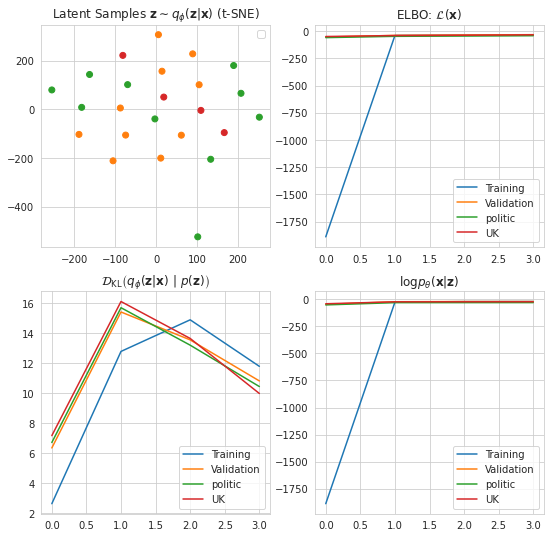

loss   | mean =      4.045, shape: []
elbo   | mean =    -32.498, shape: [256]
log_px | mean =    -21.671, shape: [256]
kl     | mean =     10.827, shape: [256]



latent_features = 128 | beta=0.1  |  learning_rate=0.0001 
[]


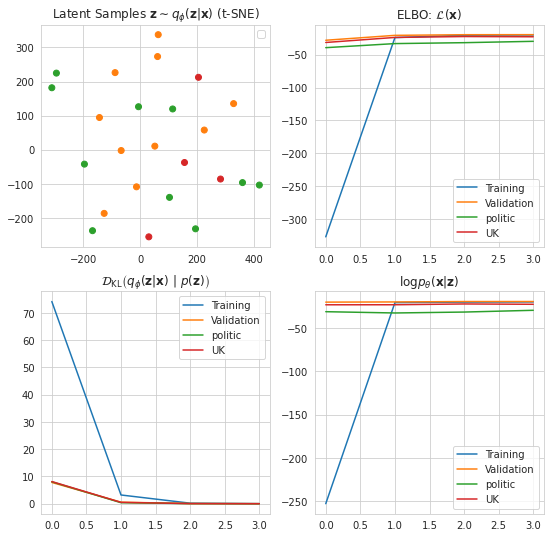

loss   | mean =      3.477, shape: []
elbo   | mean =    -19.583, shape: [256]
log_px | mean =    -19.555, shape: [256]
kl     | mean =      0.028, shape: [256]



latent_features = 128 | beta=0.1  |  learning_rate=0.001 
[]


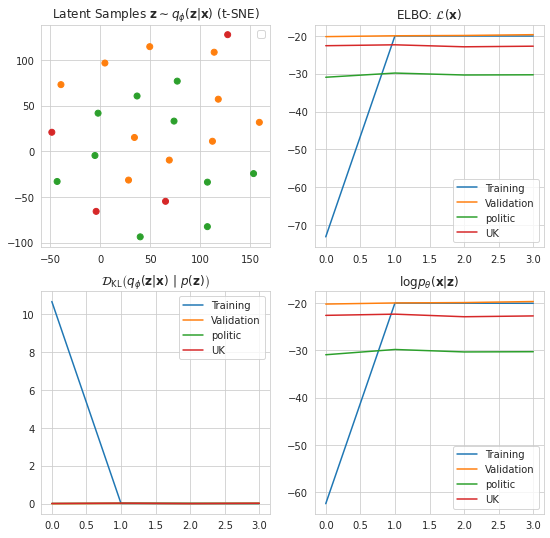

loss   | mean =      3.491, shape: []
elbo   | mean =    -19.656, shape: [256]
log_px | mean =    -19.639, shape: [256]
kl     | mean =      0.017, shape: [256]



latent_features = 128 | beta=1  |  learning_rate=1e-05 
[]


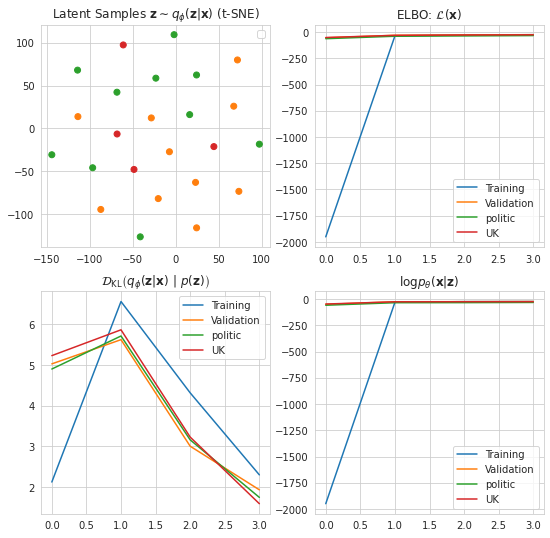

loss   | mean =      4.363, shape: []
elbo   | mean =    -24.543, shape: [256]
log_px | mean =    -22.616, shape: [256]
kl     | mean =      1.928, shape: [256]



latent_features = 128 | beta=1  |  learning_rate=0.0001 
[]


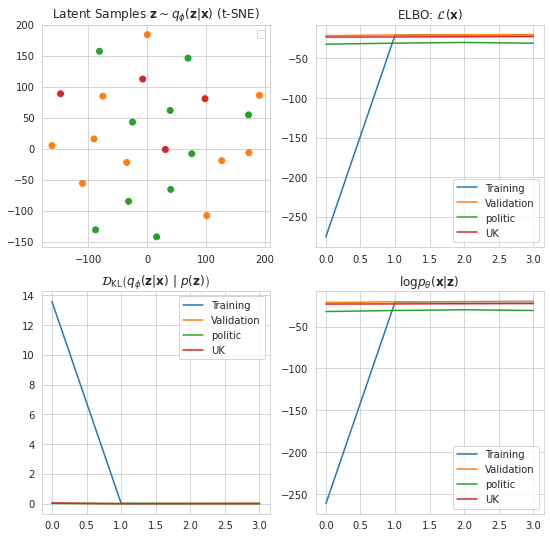

loss   | mean =      3.554, shape: []
elbo   | mean =    -19.992, shape: [256]
log_px | mean =    -19.978, shape: [256]
kl     | mean =      0.014, shape: [256]



latent_features = 128 | beta=1  |  learning_rate=0.001 
[]


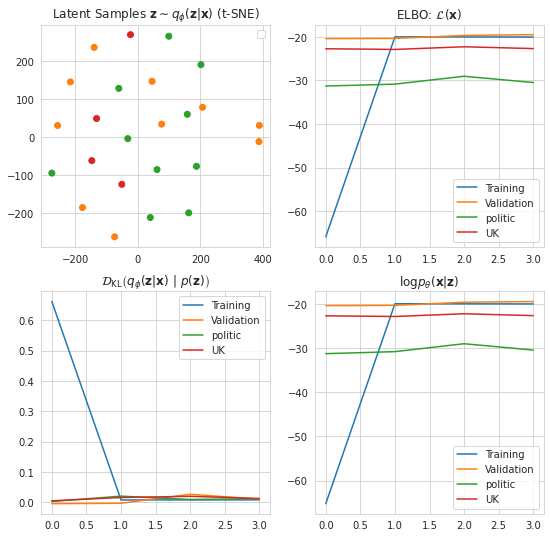

loss   | mean =      3.461, shape: []
elbo   | mean =    -19.473, shape: [256]
log_px | mean =    -19.462, shape: [256]
kl     | mean =      0.011, shape: [256]



latent_features = 128 | beta=10  |  learning_rate=1e-05 
[]


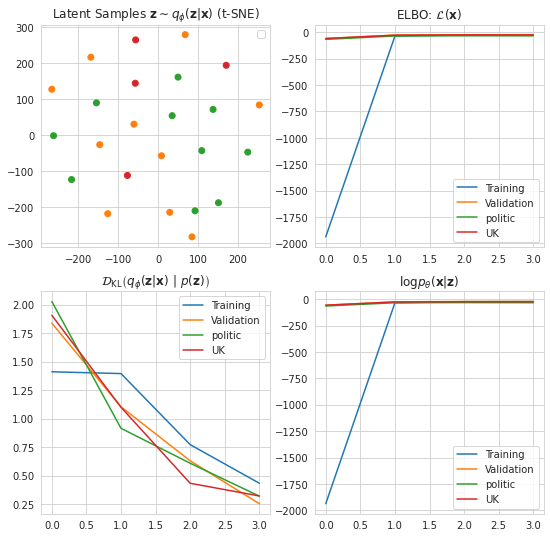

loss   | mean =      4.353, shape: []
elbo   | mean =    -22.198, shape: [256]
log_px | mean =    -21.943, shape: [256]
kl     | mean =      0.255, shape: [256]



latent_features = 128 | beta=10  |  learning_rate=0.0001 
[]


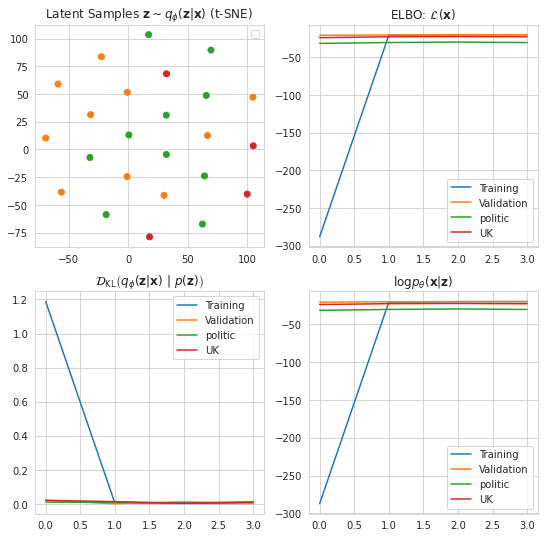

loss   | mean =      3.581, shape: []
elbo   | mean =    -20.112, shape: [256]
log_px | mean =    -20.108, shape: [256]
kl     | mean =      0.004, shape: [256]



latent_features = 128 | beta=10  |  learning_rate=0.001 
[]


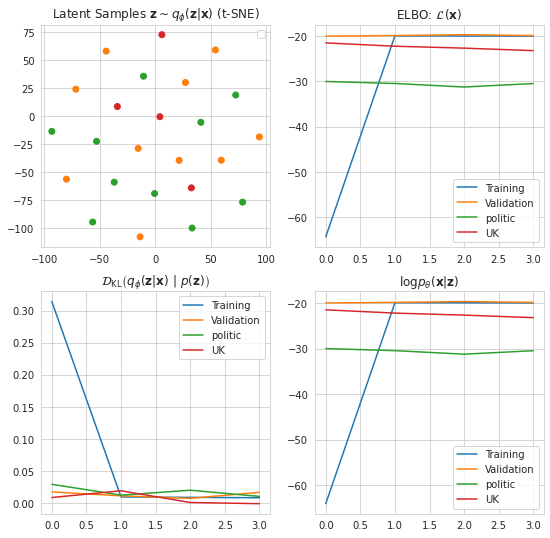

loss   | mean =      3.566, shape: []
elbo   | mean =    -19.909, shape: [256]
log_px | mean =    -19.892, shape: [256]
kl     | mean =      0.017, shape: [256]



latent_features = 512 | beta=0.1  |  learning_rate=1e-05 
[]


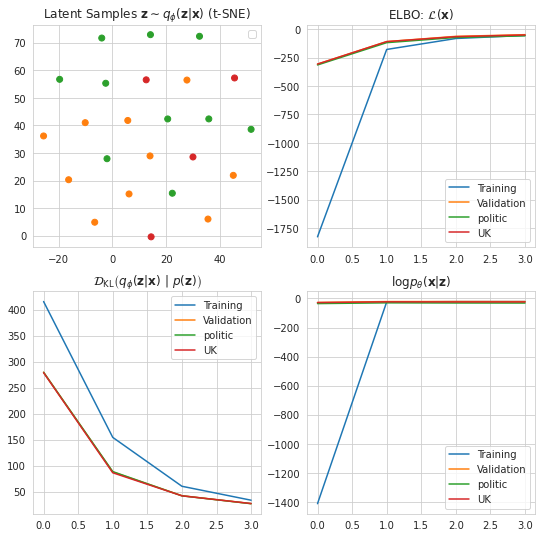

loss   | mean =      4.254, shape: []
elbo   | mean =    -48.159, shape: [256]
log_px | mean =    -21.238, shape: [256]
kl     | mean =     26.921, shape: [256]



latent_features = 512 | beta=0.1  |  learning_rate=0.0001 
[]


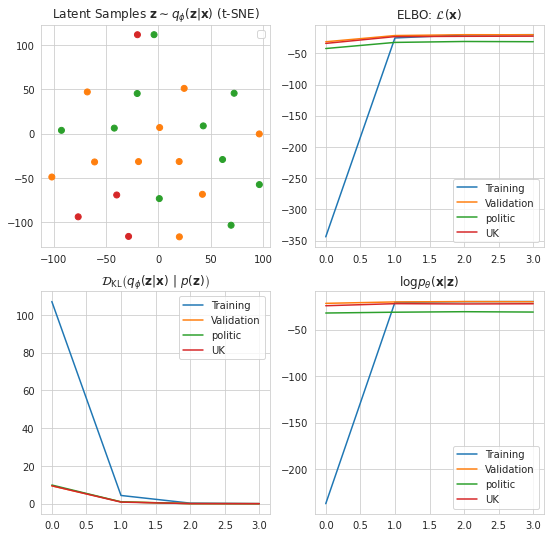

loss   | mean =      3.583, shape: []
elbo   | mean =    -20.159, shape: [256]
log_px | mean =    -20.159, shape: [256]
kl     | mean =      0.001, shape: [256]



latent_features = 512 | beta=0.1  |  learning_rate=0.001 
[]


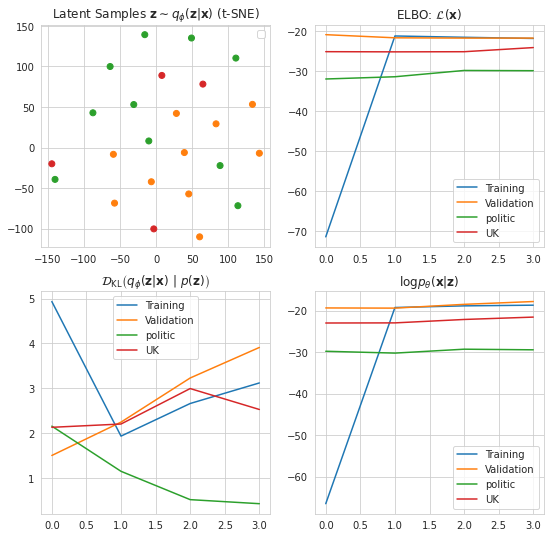

loss   | mean =      3.229, shape: []
elbo   | mean =    -21.684, shape: [256]
log_px | mean =    -17.774, shape: [256]
kl     | mean =      3.909, shape: [256]



latent_features = 512 | beta=1  |  learning_rate=1e-05 
[]


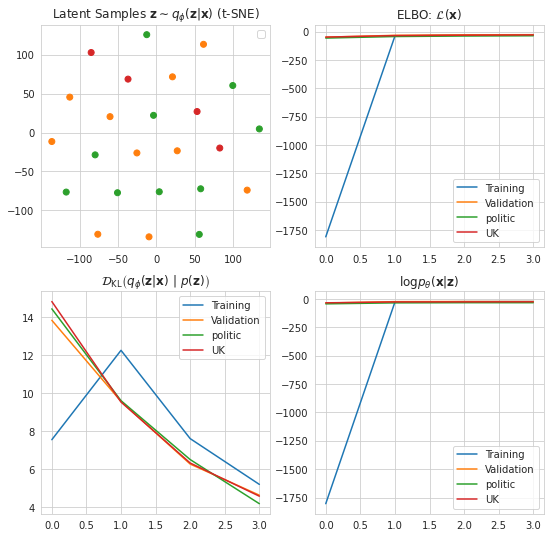

loss   | mean =      4.862, shape: []
elbo   | mean =    -27.350, shape: [256]
log_px | mean =    -22.728, shape: [256]
kl     | mean =      4.621, shape: [256]



latent_features = 512 | beta=1  |  learning_rate=0.0001 
[]


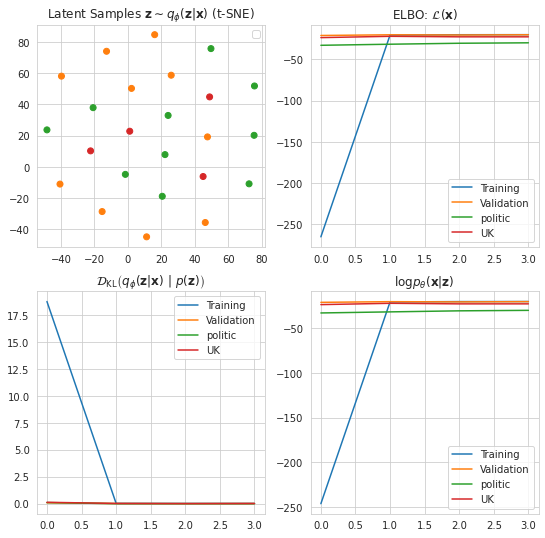

loss   | mean =      3.566, shape: []
elbo   | mean =    -20.058, shape: [256]
log_px | mean =    -20.057, shape: [256]
kl     | mean =      0.001, shape: [256]



latent_features = 512 | beta=1  |  learning_rate=0.001 
[]


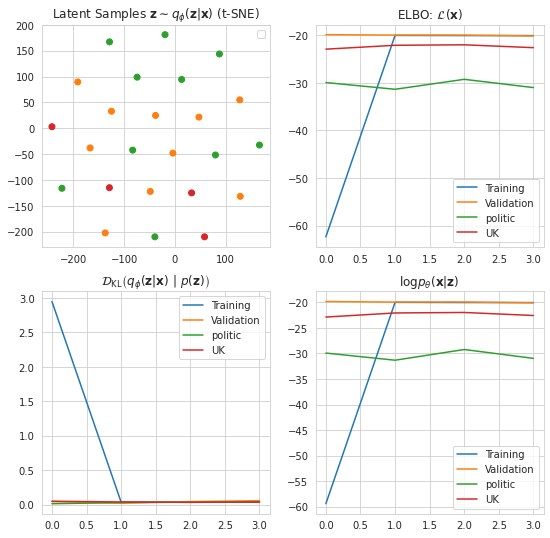

loss   | mean =      3.578, shape: []
elbo   | mean =    -20.131, shape: [256]
log_px | mean =    -20.074, shape: [256]
kl     | mean =      0.057, shape: [256]



latent_features = 512 | beta=10  |  learning_rate=1e-05 
[]


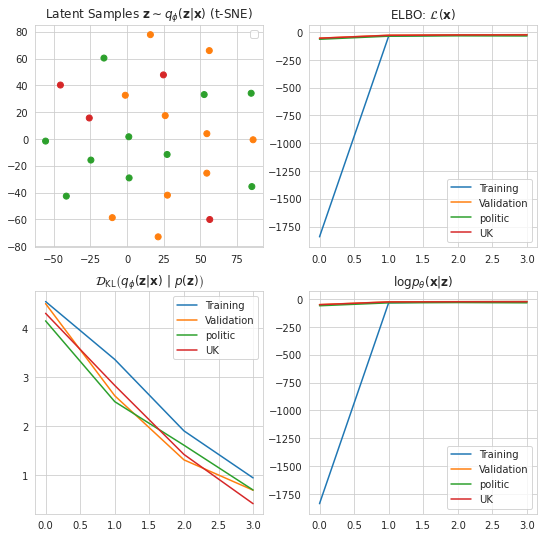

loss   | mean =      5.118, shape: []
elbo   | mean =    -22.563, shape: [256]
log_px | mean =    -21.871, shape: [256]
kl     | mean =      0.692, shape: [256]



latent_features = 512 | beta=10  |  learning_rate=0.0001 
[]


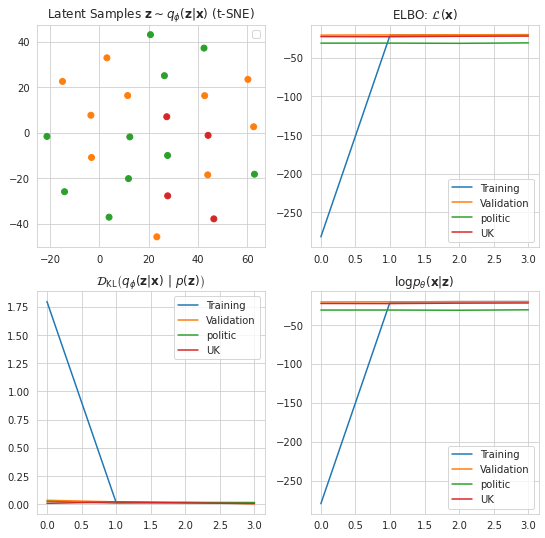

loss   | mean =      3.609, shape: []
elbo   | mean =    -20.273, shape: [256]
log_px | mean =    -20.269, shape: [256]
kl     | mean =      0.004, shape: [256]



latent_features = 512 | beta=10  |  learning_rate=0.001 
[]


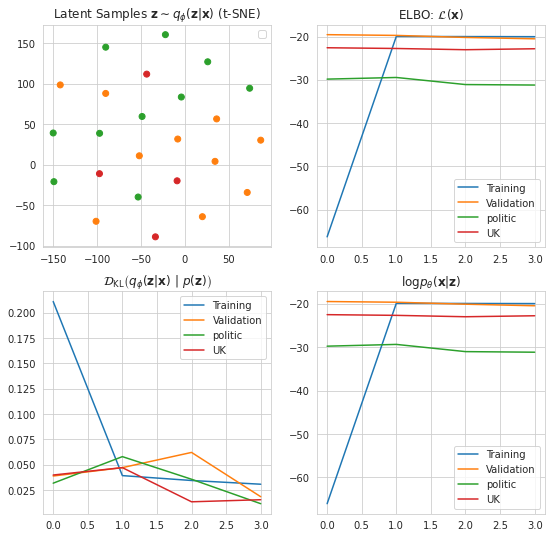

loss   | mean =      3.679, shape: []
elbo   | mean =    -20.531, shape: [256]
log_px | mean =    -20.513, shape: [256]
kl     | mean =      0.018, shape: [256]



latent_features = 1024 | beta=0.1  |  learning_rate=1e-05 
[]


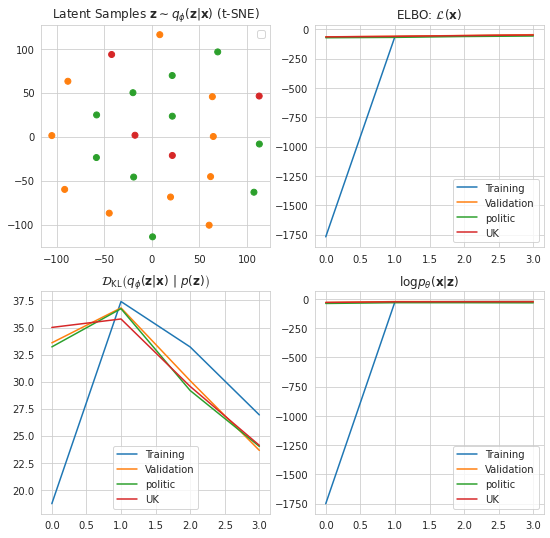

loss   | mean =      4.265, shape: []
elbo   | mean =    -45.282, shape: [256]
log_px | mean =    -21.626, shape: [256]
kl     | mean =     23.655, shape: [256]



latent_features = 1024 | beta=0.1  |  learning_rate=0.0001 
[]


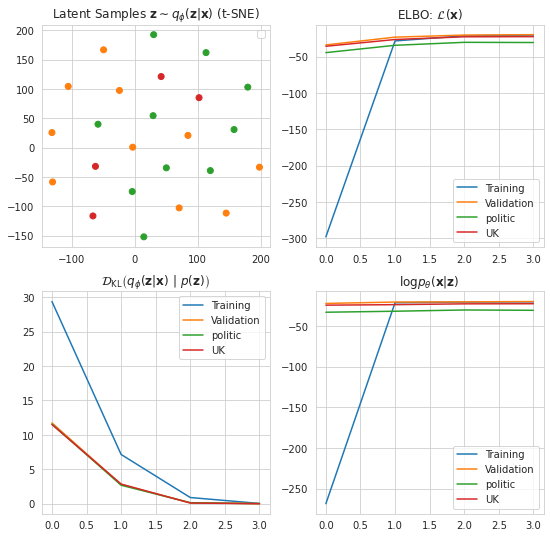

loss   | mean =      3.493, shape: []
elbo   | mean =    -19.677, shape: [256]
log_px | mean =    -19.645, shape: [256]
kl     | mean =      0.033, shape: [256]



latent_features = 1024 | beta=0.1  |  learning_rate=0.001 
[]


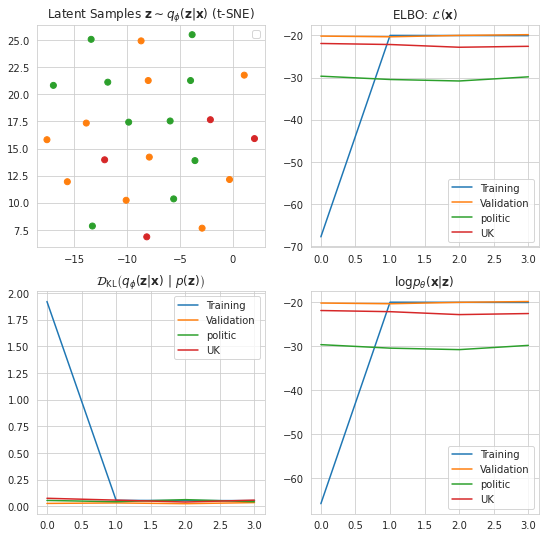

loss   | mean =      3.520, shape: []
elbo   | mean =    -19.833, shape: [256]
log_px | mean =    -19.797, shape: [256]
kl     | mean =      0.036, shape: [256]



latent_features = 1024 | beta=1  |  learning_rate=1e-05 
[]


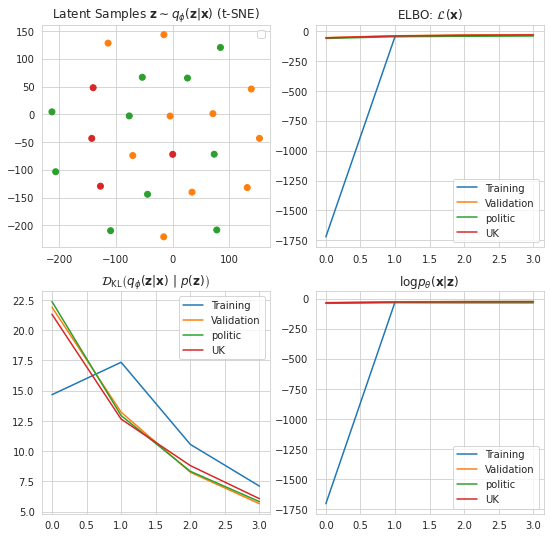

loss   | mean =      5.075, shape: []
elbo   | mean =    -28.548, shape: [256]
log_px | mean =    -22.882, shape: [256]
kl     | mean =      5.666, shape: [256]



latent_features = 1024 | beta=1  |  learning_rate=0.0001 
[]


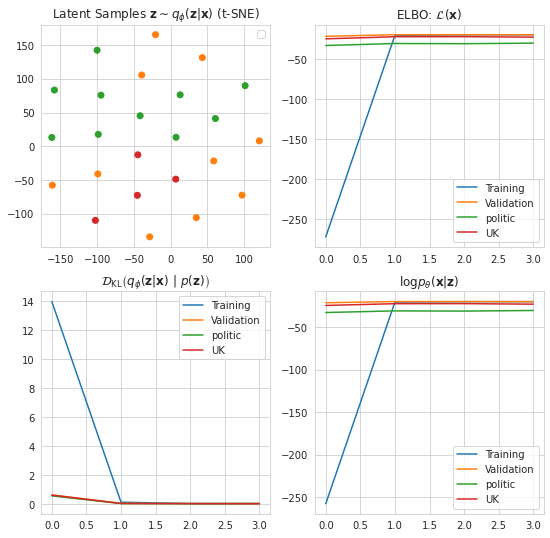

loss   | mean =      3.552, shape: []
elbo   | mean =    -19.983, shape: [256]
log_px | mean =    -19.966, shape: [256]
kl     | mean =      0.018, shape: [256]



latent_features = 1024 | beta=1  |  learning_rate=0.001 
[]


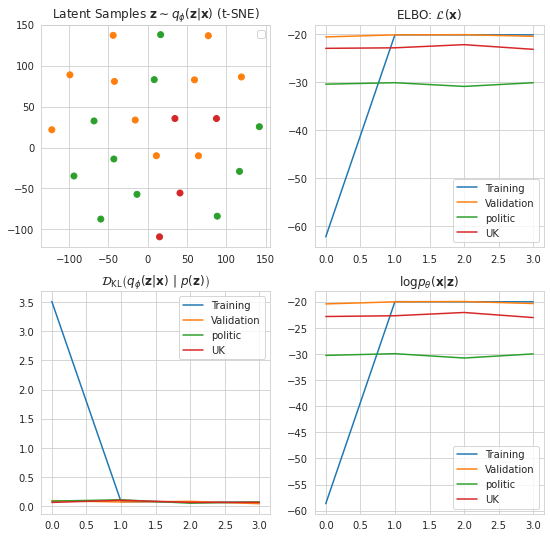

loss   | mean =      3.623, shape: []
elbo   | mean =    -20.382, shape: [256]
log_px | mean =    -20.339, shape: [256]
kl     | mean =      0.042, shape: [256]



latent_features = 1024 | beta=10  |  learning_rate=1e-05 
[]


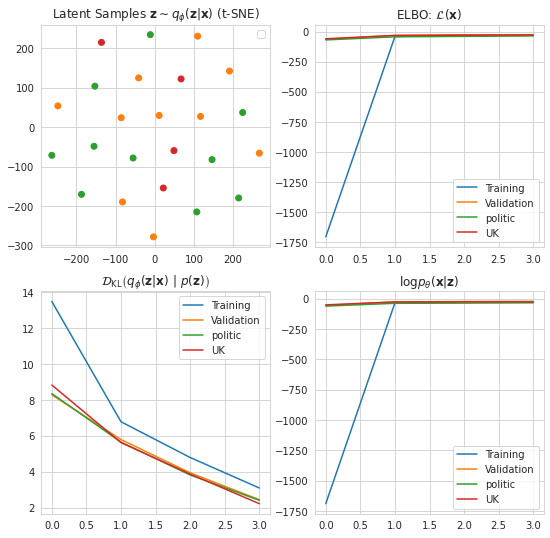

loss   | mean =      8.531, shape: []
elbo   | mean =    -26.084, shape: [256]
log_px | mean =    -23.649, shape: [256]
kl     | mean =      2.434, shape: [256]



latent_features = 1024 | beta=10  |  learning_rate=0.0001 
[]


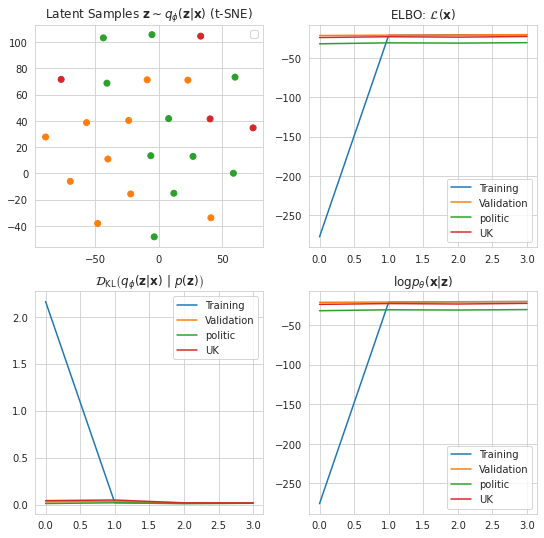

loss   | mean =      3.578, shape: []
elbo   | mean =    -19.968, shape: [256]
log_px | mean =    -19.951, shape: [256]
kl     | mean =      0.018, shape: [256]



latent_features = 1024 | beta=10  |  learning_rate=0.001 
[]


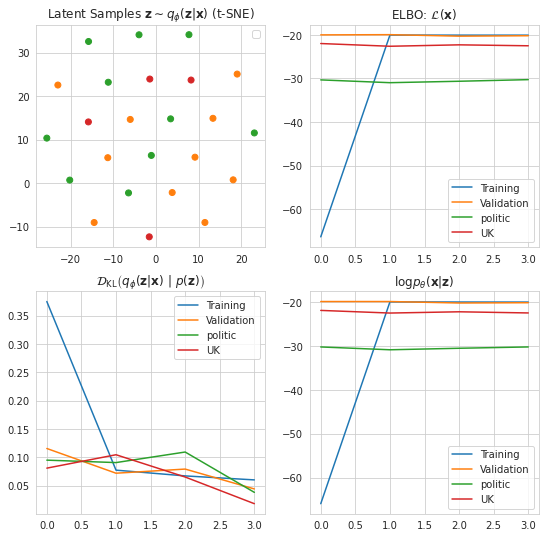

loss   | mean =      3.661, shape: []
elbo   | mean =    -20.194, shape: [256]
log_px | mean =    -20.150, shape: [256]
kl     | mean =      0.044, shape: [256]





In [15]:
num_epochs = 4

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")



Latent_features=[ 128, 512, 1024]
Betas=[ 0.1, 1, 10]
Learning_rates=[0.00001, 0.0001, 0.001]

for latent_features in Latent_features:
  for beta in Betas:
    for learning_rate in Learning_rates:

      # define dictionary to store the training curves
      training_data = defaultdict(list)
      validation_data = defaultdict(list)
      validation_data_politic = defaultdict(list)
      validation_data_UK = defaultdict(list)

      epoch = 0
      vae = VariationalAutoencoder(tfidf_m[0].shape, latent_features)
      # print(vae)

      vi = VariationalInference(beta=beta)

      # The Adam optimizer works really well with VAEs.
      optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)
      # move the model to the device
      vae = vae.to(device)
      matches=matches.to(device) 
      
      while epoch < num_epochs:
          epoch+= 1
         # print("epoch "+str(epoch))
          training_epoch_data = defaultdict(list)
          vae.train()
          
          # Go through each batch in the training dataset using the loader
          # Note that y is not necessarily known as it is here
          i=0
          for x in train_loader:
              x = x.to(device)
              if(i*batch_size>mUSA_train.shape[0]):
                  break
              # perform a forward pass through the model and compute the ELBO
              loss, diagnostics, outputs = vi(vae, x)
              
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
              
              # gather data for the current bach
              for k, v in diagnostics.items():
                  training_epoch_data[k] += [v.mean().item()]
              i+=1

          # gather data for the full epoch
          if(epoch>-1):
              for k, v in training_epoch_data.items():
                  training_data[k] += [np.mean(training_epoch_data[k])]

          # Evaluate on a single batch, do not propagate gradients
          with torch.no_grad():
              vae.eval()
              
              # Just load a single batch from the test loader
              x = next(iter(test_loader))
              x = x.to(device)
              
              # perform a forward pass through the model and compute the ELBO
              loss, diagnostics, outputs = vi(vae, x)
              
              x_politic = next(iter(test_loader_politic))
              x_politic= x_politic.to(device)
              
              # perform a forward pass through the model and compute the ELBO
              loss_politic, diagnostics_politic, outputs_politic = vi(vae, x_politic)
              
              x_UK = next(iter(test_loader_UK))
              x_UK = x_UK.to(device)
              
              # perform a forward pass through the model and compute the ELBO
              loss_UK, diagnostics_UK, outputs_UK = vi(vae, x_UK)
              # gather data for the validation step
              
              loss_matches, diagnostics_matches, outputs_matches = vi(vae, matches)
              
              # gather data for the validation step
              if(epoch>-1):
                  for k, v in diagnostics.items():
                      validation_data[k] += [v.mean().item()]
                  for k, v in diagnostics_politic.items():
                      validation_data_politic[k] += [v.mean().item()]
                  for k, v in diagnostics_UK.items():
                      validation_data_UK[k] += [v.mean().item()]
                  
      print(f"latent_features = {latent_features} | beta={beta}  |  learning_rate={learning_rate} ")
      make_vae_plots(vae, x, y, outputs, outputs_matches, training_data, validation_data,validation_data_politic,validation_data_UK)
          ##Reproduce the figure from the begining of the notebook, plot the training curves and show latent samples
          #if(epoch>-1):
              #make_vae_plots(vae, x, y, outputs, outputs_matches, training_data, validation_data)
              
              #make_vae_plots(vae, x, y, outputs, outputs_matches, training_data, validation_data,validation_data_politic,validation_data_UK)

      print(f"{'loss':6} | mean = {loss:10.3f}, shape: {list(loss.shape)}")
      for key, tensor in diagnostics.items():
          print(f"{key:6} | mean = {tensor.mean():10.3f}, shape: {list(tensor.shape)}")
      print("\n\n")



In [ ]:
make_vae_plots(vae, x, y, outputs, outputs_matches, training_data, validation_data,validation_data_politic,validation_data_UK)
#make_vae_plots(vae, x, y, outputs, outputs_matches, training_data, validation_data)
loss, diagnostics, outputs = vi(vae, x)
print(f"{'loss':6} | mean = {loss:10.3f}, shape: {list(loss.shape)}")
for key, tensor in diagnostics.items():
    print(f"{key:6} | mean = {tensor.mean():10.3f}, shape: {list(tensor.shape)}")

In [ ]:

loss_matches, diagnostics_matches, outputs_matches = vi(vae, matches)
px=outputs_matches['px']
output=px.sample()
matchescpu=matches.cpu()
outputcpu=output.cpu()
#print(pz)
#print(qz)
for i in range(55) :
  print(vec.inverse_transform(matchescpu[i]))
  print(vec.inverse_transform(outputcpu[i]))
  print(i)
  #print(outputs_matches['x'])
  #print(vec.inverse_transform(tfidfTweet))
  #print(str(matches[i])+str(vec.inverse_transform(tfidfTweet)))
  i=i+1